In [1]:
from argparse import ArgumentParser
import os
import shutil
from tqdm import tqdm
import numpy as np
import torch
from feature_extractors import AlexNetFC6, AlexNetConv5, AlexNetFull
from utils import listdir, image_to_tensor
from scipy.stats import pearsonr
from utils import p2r, stack_features, word2sense, regression, cv_regression_w2s, image_to_tensor, Subject, listdir, correlation

In [21]:
#feat_extractor = AlexNetFC6()
#feat_extractor = AlexNetConv5() # [stim, 256, 7, 7]
feat_extractor = AlexNetFull()

conditions = listdir('images')

# Setup w2s
w2s_file = "ThingsWrd2Sns.txt"
_, w2s_embeddings = word2sense(w2s_file)
nDim = 2250

# condition_features = {}
# for c in tqdm(conditions):
#     c_name = c.split('/')[-1]
#     stimuli = listdir(c)
#     stimuli = [image_to_tensor(s, resolution=255) for s in stimuli]
#     stimuli = torch.stack(stimuli) # stacked in 10
#     #if torch.cuda.is_available():
#     #    stimuli = stimuli.cuda()
#     feats = []
#     with torch.no_grad():
#         _, c2, c3, c4, c5, fc6, _ = feat_extractor(stimuli)
#     c2 = c2.mean(dim=0)
#     c3 = c3.mean(dim=0)
#     c4 = c4.mean(dim=0)
#     c5 = c5.mean(dim=0)
#     fc6 = fc6.mean(dim=0)
#     feats.append(c2)
#     feats.append(c3)
#     feats.append(c4)
#     feats.append(c5)
#     feats.append(fc6)
#     condition_features[c_name] = feats


In [64]:
condition_features = np.load('features_all_unflattened.npy', allow_pickle=True)
#print(condition_features.item().get('aardvark'))
nfeat = 0
for l in condition_features.item().get('aardvark'):
    if l.shape[0] == 4096:
        continue
    nfeat = nfeat + l.shape[0]
    print(l.shape)
print(nfeat)
features = np.zeros((len(w2s_embeddings), nfeat))

idx = 0
for i, condition in enumerate(condition_features.item()):
    c_name = condition.split('/')[-1]
    if c_name in w2s_embeddings:
        feat = 0
        for l, layer in enumerate(condition_features.item().get(condition)):
            if layer.shape[0] == 4096:
                continue
            for filt in range(layer.shape[0]):
                features[idx, feat] = np.amax(np.array(layer[filt]))
                feat = feat + 1
        idx = idx + 1
print(feat)
            
# features = np.zeros((1470, 256)) #4096, 256
voxels = np.zeros((1470, 195))
w2s = np.zeros((1470, 2250))

# condition_features_ = torch.load('features_conv5.pth')

# #condition_features_ = torch.load('features_fc6.pth')
# print(len(condition_features_))

idx = 0
for i, c in enumerate(condition_features.item()):
    c_name = c.split('/')[-1]
    if c_name in w2s_embeddings:
        voxel = np.load('./predicted_LOC_conv5' + '/' + c_name + '/' + c_name + '.npy')
        #print(voxel.shape)
        voxels[idx, :] = voxel
        w2s[idx, :] = w2s_embeddings[c_name]
        idx = idx + 1

torch.Size([192, 15, 15])
torch.Size([384, 15, 15])
torch.Size([256, 15, 15])
torch.Size([256, 7, 7])
1088
1088


In [65]:
corr_featvox = np.zeros((feat, 195))

for i in range(feat):
    for j in range(195):
        corr_featvox[i, j] = (correlation(features[:, i], voxels[:, j]))

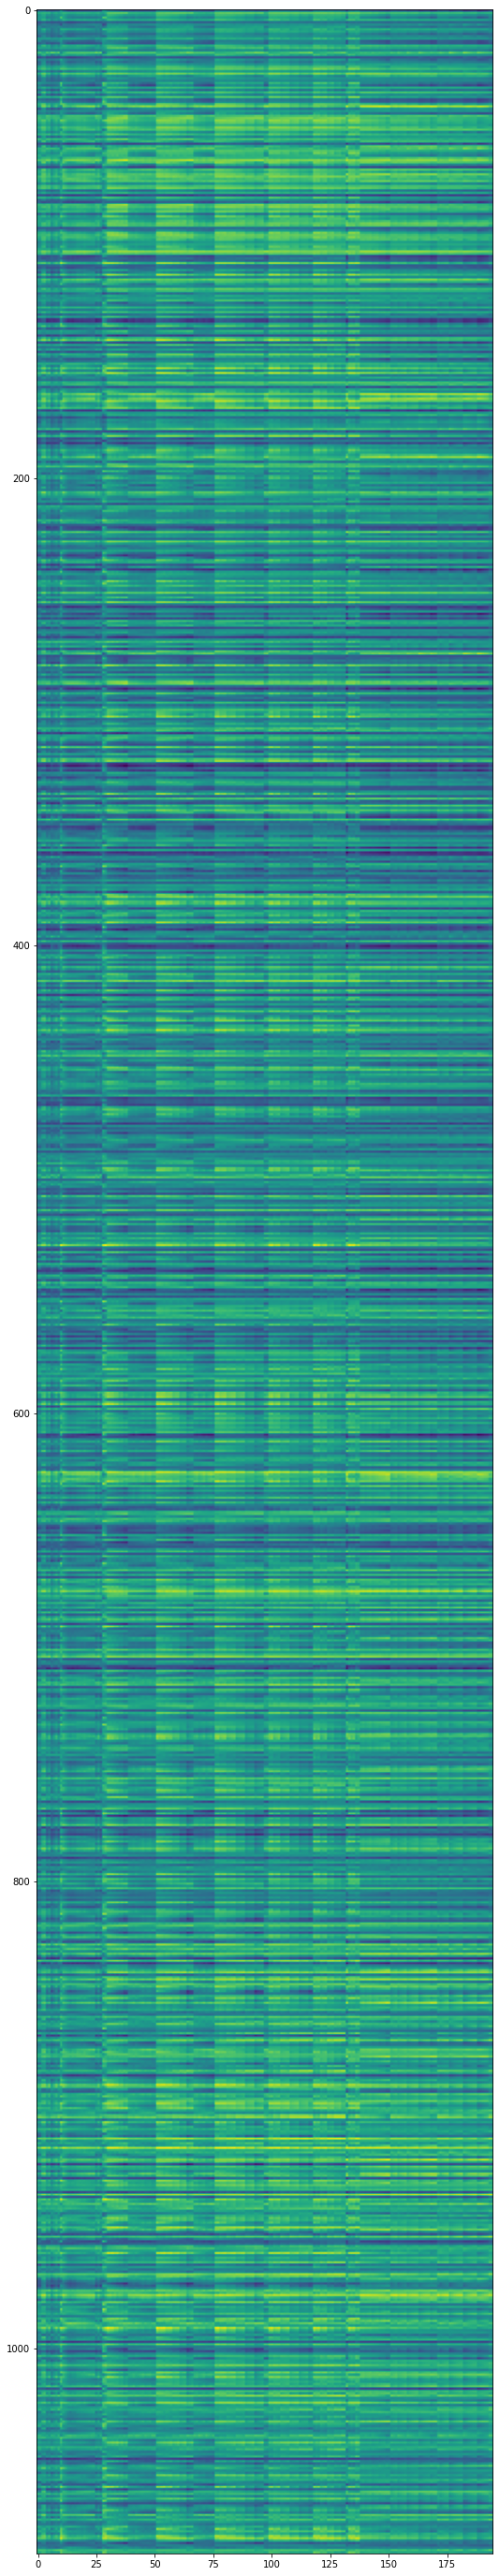

In [66]:
r_threshold = p2r(0.05/feat, 1470)

corr_featvox_t = corr_featvox > r_threshold

feat_t = np.zeros((feat, 1))

for i in range(feat):
    feat_t[i] = np.sum(corr_featvox_t[i, :])

import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
plt.imshow(corr_featvox)
plt.show()


In [67]:
feat_argmax = ((feat_t.T).argsort())[0][::-1]

In [68]:
feat_argmax_100 = feat_argmax[0:100]

In [69]:
feat_random_100 = np.random.choice(feat, 100, replace=False)

feat_top = features[:, feat_argmax_100]
feat_random = features[:, feat_random_100]

feat_top_r = []
feat_random_r = []


In [70]:
print ("cross-validation with top or random features")

_, voxel_mean_r = cv_regression_w2s(feat_top, w2s_embeddings, fit=None, k=9, l2=0.0, pc=None)
print(voxel_mean_r)
feat_top_r.append(voxel_mean_r)

_, voxel_mean_r = cv_regression_w2s(feat_random, w2s_embeddings, fit=None, k=9, l2=0.0, pc=None)
print(voxel_mean_r)
feat_random_r.append(voxel_mean_r)


cross-validation with top or random features


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2

[0.11678445 0.02753897 0.1061323  ... 0.08784352 0.13023903 0.09923571]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2

[0.15165105 0.08390931 0.05409793 ... 0.10034152 0.06307143 0.12669131]


/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:262: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda v: (v - v.mean(0)) / v.std(0)
/home/chan21/projects/semanticdimensionality/kh/object2vec_encoder_python/utils.py:79: RuntimeWarning: Mean of empty slice
  mean_r = np.nanmean(rs, axis=0) # mean across k folds


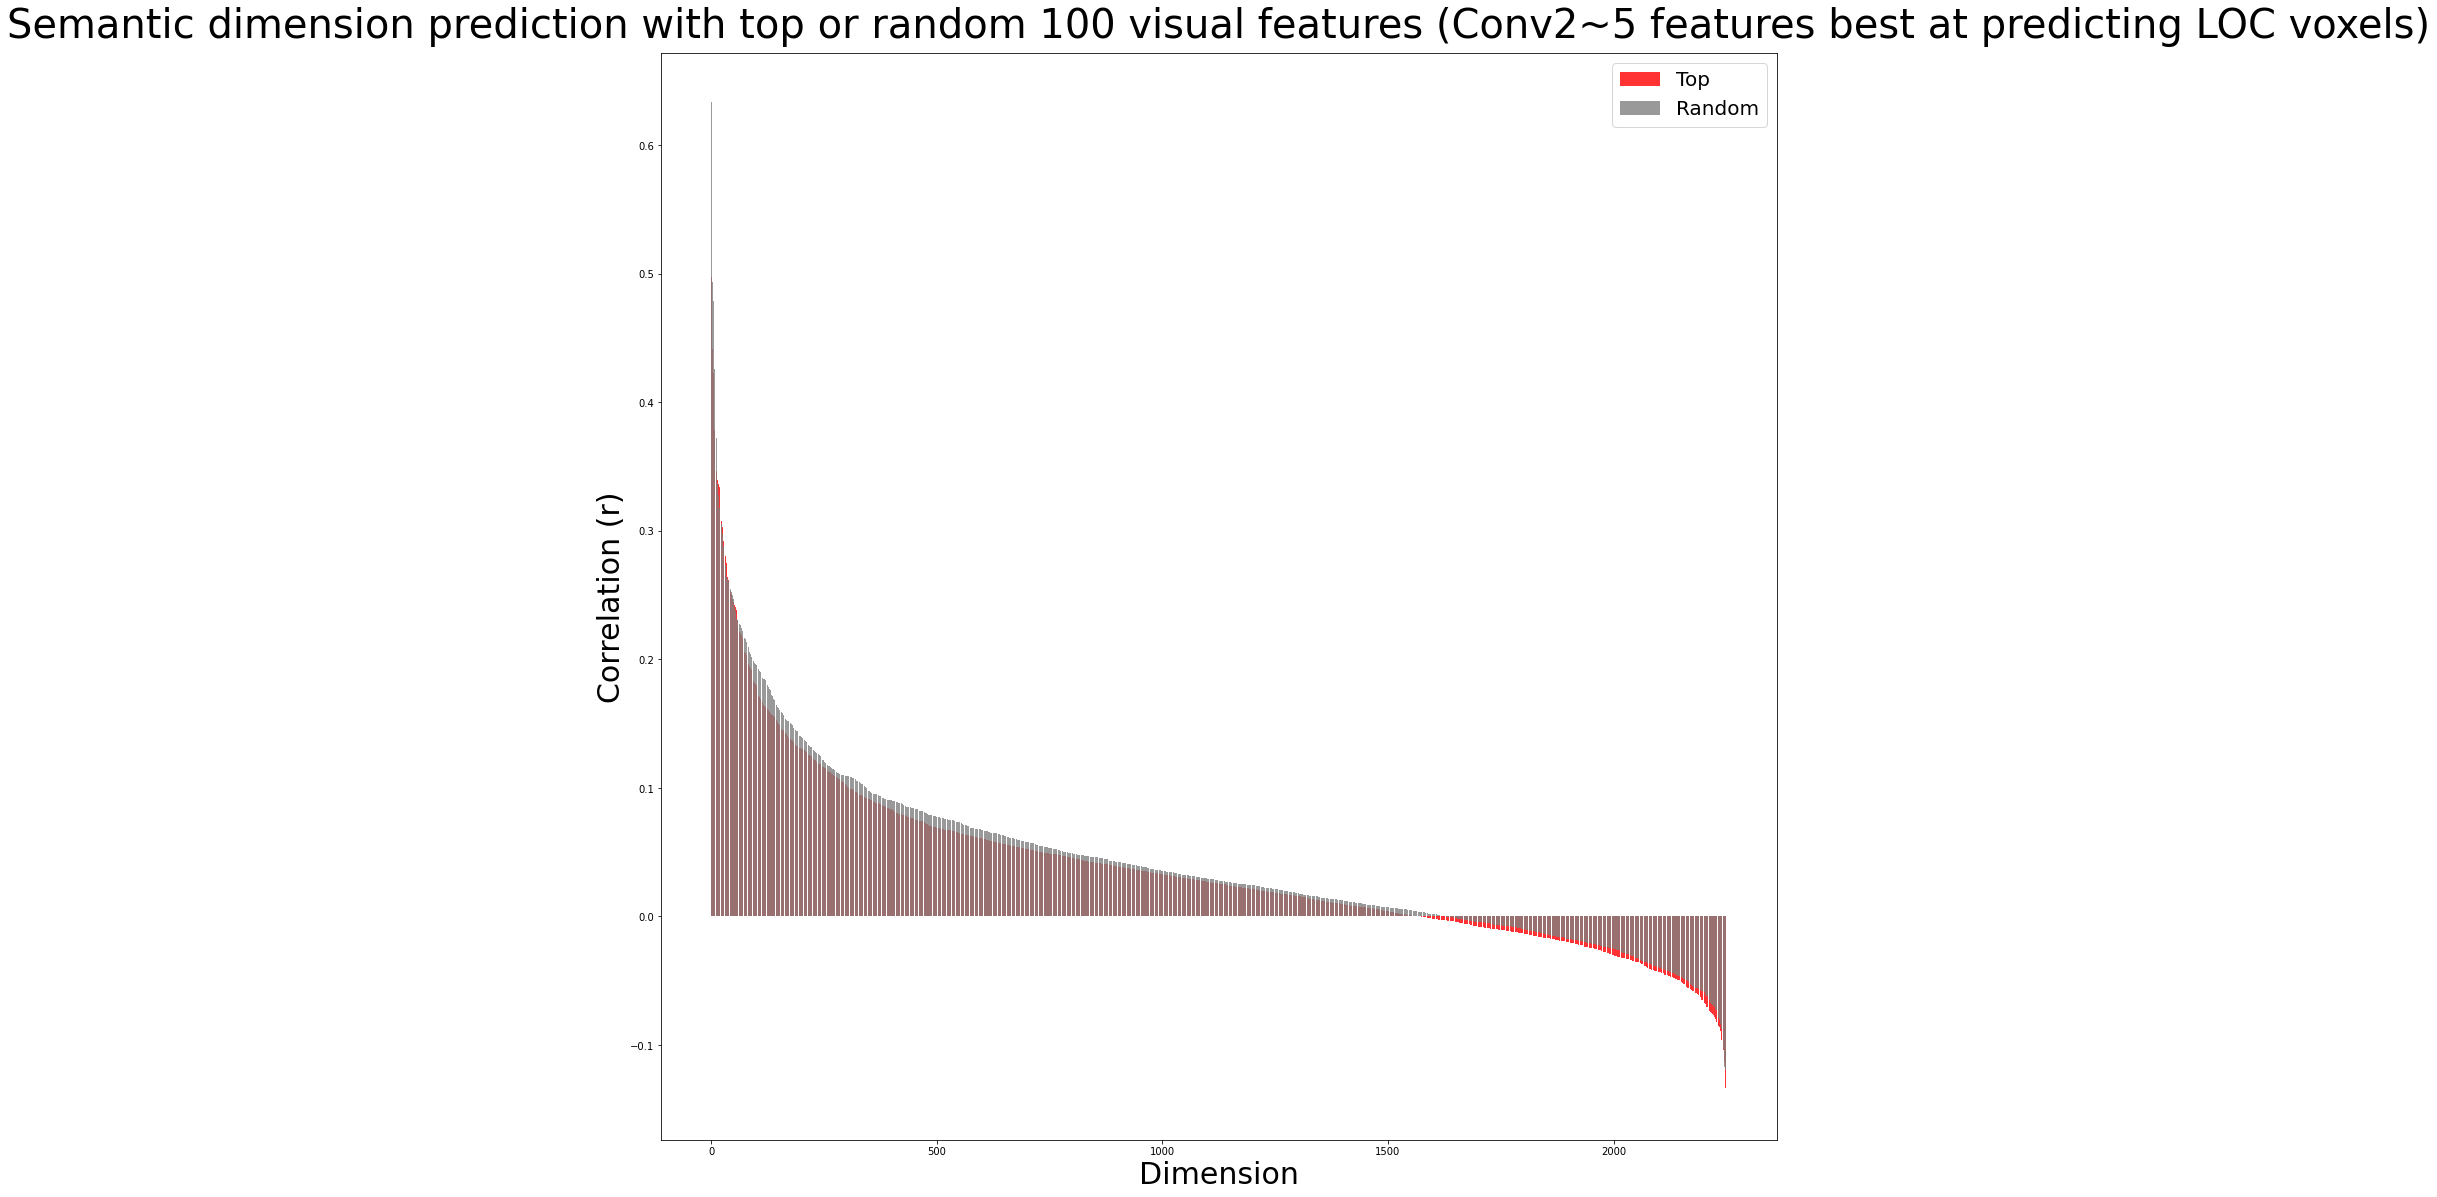

In [82]:
fig = plt.figure(figsize=(20, 20))

x = np.arange(0, 2250, 1)
title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}
plt.title("Semantic dimension prediction with top or random 100 visual features (Conv2~5 features best at predicting LOC voxels)", **title_font)

plt.bar(range(0,2250), np.sort(np.array(feat_top_r[0]))[::-1], color='red', label='Top', alpha=0.8)
plt.bar(range(0,2250), np.sort(np.array(feat_random_r[0]))[::-1], color='grey', label='Random', alpha=0.8)
plt.legend(prop={'size': 20})
plt.xlabel('Dimension', **axis_font)
plt.ylabel('Correlation (r)', **axis_font)
plt.show()

In [78]:
r_threshold = p2r(0.05/2250, 1470)

top_dim_set = {}
top_max_set = {}
top_mean_set = {}
top_med_set = {}

top_dim = []
top_max = []
top_mean = []
top_med = []
for dim_pred in feat_top_r:
    dim_pred = np.array(dim_pred)
    dim_pred_score = np.sum(dim_pred > r_threshold)
    dim_max = np.nanmax(dim_pred)
    dim_mean = np.nanmean(np.array(dim_pred))
    dim_med = np.nanmedian(np.array(dim_pred))
    top_dim.append(dim_pred_score)
    top_max.append(dim_max)
    top_mean.append(dim_mean)
    top_med.append(dim_med)
top_dim_set = top_dim
top_max_set = top_max
top_mean_set = top_mean
top_med_set = top_med

random_dim_set = {}
random_max_set = {}
random_mean_set = {}
random_med_set = {}


random_dim = []
random_max = []
random_mean = []
random_med = []
for dim_pred in feat_random_r:
    dim_pred = np.array(dim_pred)
    dim_pred_score = np.sum(dim_pred > r_threshold)
    dim_max = np.nanmax(dim_pred)
    dim_mean = np.nanmean(np.array(dim_pred))
    dim_med = np.nanmedian(np.array(dim_pred))
    random_dim.append(dim_pred_score)
    random_max.append(dim_max)
    random_mean.append(dim_mean)
    random_med.append(dim_med)
random_dim_set = random_dim 
random_max_set = random_max
random_mean_set = random_mean
random_med_set = random_med

In [79]:
print(top_dim_set)
print(top_max_set)
print(top_mean_set)
print(top_med_set)
print(random_dim_set)
print(random_max_set)
print(random_mean_set)
print(random_med_set)

[284]
[0.4977801234577231]
[0.0377842793072291]
[0.025743860939377253]
[321]
[0.6336144840622926]
[0.04278308338216163]
[0.02811118578845484]


In [ ]:
pred_feat_top = np.zeros((100, 2250))
pred_feat_random = np.zeros((100, 2250))
r_threshold2 = p2r(0.05/2250, 1470)


for i in range(100):
    for j in range(2250):
        pred_feat_top[i, j] = (correlation(feat_top[:, i], w2s[:, j]))
        #pred_feat_random[i, j] = (correlation(feat_random[:, i], w2s[:, j]))

print("predicting w2s with top 100 fc6 features")

In [ ]:
pred_feat_top_score = np.zeros((100, 1))
for i in range(100):
    pred_feat_top_score[i] = (np.sum(pred_feat_top[i, :] > r_threshold2))

print((pred_feat_top_score.T)[0])



In [ ]:
pred_feat_random_score = np.zeros((100, 10))

for n in range(10):
    feat_randomarg = random.sample(range(4096), 100)
    feat_random = features[:, feat_randomarg]
    print(feat_random.shape)
    for i in range(100):
        for j in range(2250):
            #pred_feat_top[i, j] = (correlation(feat_top[:, i], w2s[:, j]))
            pred_feat_random[i, j] = (correlation(feat_random[:, i], w2s[:, j]))
    print("predicting w2s with random 100 fc6 features, " + str(n))
    #print(np.sum(pred_feat_random > r_threshold2)) 

In [ ]:

for n in range(10):
    for i in range(100):
        pred_feat_random_score[i, n] = (np.sum(pred_feat_random[i, :] > r_threshold2))
        #print(np.sum(pred_feat_random[i, :] > r_threshold2))


In [ ]:
print(np.sort(pred_feat_top_score.T))
print(pred_feat_random_score[:, 0])


fig = plt.figure(figsize=(20, 25))

#ax.bar(idx,r)
plt.bar(range(0,100), np.sort(pred_feat_top_score.T)[0][::-1], color='darkred', label='top', alpha=0.8)
for i in range(10):
    plt.bar(range(0,100), np.sort(pred_feat_random_score[:, i])[::-1], color='grey', label='random', alpha=0.1)

plt.legend(prop={'size': 20})

plt.show()